## CART using Python

### Import required Libraries

In [1]:
import pandas                   as      pd
import numpy                    as      np
import sklearn.datasets         as      datasets
import matplotlib.pyplot        as      plt

from   sklearn                  import  tree
from   sklearn.tree             import  DecisionTreeClassifier
from   sklearn.tree             import _tree

from   sklearn                  import  metrics 
from   sklearn.metrics          import  classification_report
from   sklearn.metrics          import  confusion_matrix
from   sklearn.metrics          import  roc_curve, auc
from   sklearn.model_selection  import  KFold 
from   sklearn.model_selection  import  train_test_split

from   sklearn.cross_validation import  cross_val_score
from   sklearn.cross_validation import  KFold


import pydotplus
import pydot

%matplotlib inline

D:\Python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def draw_cm( actual, predicted ):
    
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels = ["Yes", "No"] , yticklabels = ["Yes", "No"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()   

In [3]:
def draw_roc( actual, probs ):

    import pandas            as   pd
    import numpy             as   np
    import seaborn           as   sns
    import matplotlib.pyplot as   plt
    import sklearn.metrics   as   metrics
    import seaborn           as   sns
    
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
    drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [4]:
def decision_tree_no_pruning(model, X, y, flist, file_name):
    from sklearn.tree            import export_graphviz
    from sklearn.externals.six   import StringIO  
    from IPython.core.pylabtools import figsize
    from IPython.display         import Image
    figsize(12.5, 6)
    import pydot

    #dot_data = StringIO()  
    file_name_dot = file_name + '.dot'
    file_name_png = file_name + '.png'
    
    export_graphviz(model, out_file = file_name_dot, feature_names = flist,\
                    class_names = ['No Diabetes' , 'Diabetes'],
                    filled = True, rounded = True)
    (graph,) = pydot.graph_from_dot_file(file_name_dot)
    graph.write_png(file_name_png)
    return Image(file_name_png)

In [5]:
def decision_tree_with_pruning(clf, X, y, flist, file_name):
    from sklearn.tree            import export_graphviz
    from sklearn.externals.six   import StringIO  
    from IPython.core.pylabtools import figsize
    from IPython.display         import Image
    figsize(12.5, 6)
    import pydot
    #dot_data = StringIO()  
    file_name_dot = file_name + '.dot'
    file_name_png = file_name + '.png'
    
    export_graphviz(clf, out_file = file_name_dot, feature_names = flist,
                    class_names = ['No Diabetes' , 'Diabetes'],
                    filled = True, rounded = True)
    (graph,) = pydot.graph_from_dot_file(file_name_dot)
    graph.write_png(file_name_png)
    return Image(file_name_png)

In [6]:
'''
This function returns a set of rules defined in the Decision Tree which is easy to understand
'''
def tree_to_rules(tree, feature_names, class_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):

        indent = "  " * depth

        if (threshold[node] != -2):

            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")

            if left[node] != -1:

                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")

                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)

                print(indent,"}")

        else:
            if value[node][0,0] > value[node][0,1]:
              classified = class_names[0]
            else:
              classified = class_names[1]
            print(indent,"Class = " + classified)
    recurse(left, right, threshold, features, 0)

In [7]:
'''
This function calculates the Youdens J score which gives the optimum cut-off
point given the fpr, tpr and thresholds
'''
def get_youdens_j_cutoff(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

### Read data file

In [8]:
column_names    = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
df              = pd.read_csv('D:/RRD/data/pima-indians-diabetes.data.CSV', header= None, names = column_names)
df.columns

Index(['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree',
       'age', 'label'],
      dtype='object')

### Understand Data

In [9]:
feature_names   = df.columns
print(feature_names)
print(df.info())

Index(['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree',
       'age', 'label'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnant    768 non-null int64
glucose     768 non-null int64
bp          768 non-null int64
skin        768 non-null int64
insulin     768 non-null int64
bmi         768 non-null float64
pedigree    768 non-null float64
age         768 non-null int64
label       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [10]:
print(df.head(2).T)

                0       1
pregnant    6.000   1.000
glucose   148.000  85.000
bp         72.000  66.000
skin       35.000  29.000
insulin     0.000   0.000
bmi        33.600  26.600
pedigree    0.627   0.351
age        50.000  31.000
label       1.000   0.000


### Observations

* There are no missing values and data looks OK
* All variables are numeric and the following variables need to be converted to Categorical variables:

| Sl No | Variable |
|-- | ----------------------- |
| 1 | pregnant |
| 2 | insulin |
| 3 | label |

In [11]:
categorical_var =  ['pregnant','insulin','label']

numerical_var   =  feature_names.drop(categorical_var)
print(categorical_var)
print(numerical_var)

['pregnant', 'insulin', 'label']
Index(['glucose', 'bp', 'skin', 'bmi', 'pedigree', 'age'], dtype='object')


In [12]:
for i in range(len(categorical_var)):
    df[categorical_var[i]] = df[categorical_var[i]].astype('category') 

In [13]:
df.describe()

,glucose,bp,skin,bmi,pedigree,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,120.894531,69.105469,20.536458,31.992578,0.471876,33.240885
std,31.972618,19.355807,15.952218,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,99.000000,62.000000,0.000000,27.300000,0.243750,24.000000
50%,117.000000,72.000000,23.000000,32.000000,0.372500,29.000000
75%,140.250000,80.000000,32.000000,36.600000,0.626250,41.000000
max,199.000000,122.000000,99.000000,67.100000,2.420000,81.000000


In [14]:
df.describe(include = ['category'])

,pregnant,insulin,label
count,768,768,768
unique,17,186,2
top,1,0,0
freq,135,374,500


### Create X, independent variable and y dependent variable

In [15]:
feature_names  =  feature_names.drop('label')
X              =  df.loc[:,feature_names] 
y              =  df.loc[:,'label']
label_names    =  y.unique()
print(X.shape)
print(y.shape)

(768, 8)
(768,)


### Check if the data set is balanced or not

In [16]:
y.value_counts().apply(lambda x: [x, ( x * 100) / df.shape[0]])

0     [500, 65.10416666666667]
1    [268, 34.895833333333336]
Name: label, dtype: object

Since class, 1 (Churn) customers form only 12% of the data set, we have a unbalanced data set.

### Split the data into training and test data set

In [17]:
seed      = 1
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify = y) 

In [18]:
clf    = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf    = clf.fit(X_train,y_train)

In [19]:
#Predict the response for train dataset
predicted_train = clf.predict(X_train)


Training Data
[[350   0]
 [  0 187]]


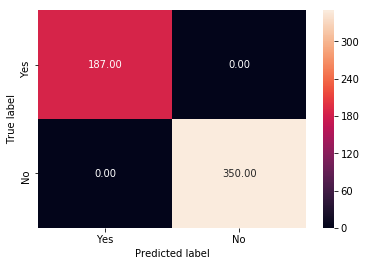

Training Accuracy: 100.000%


In [20]:
matrix             = confusion_matrix(y_train, predicted_train)
print("\nTraining Data")
print(matrix)
draw_cm(y_train, predicted_train )
    
accuracy_train = clf.score(X_train, y_train) 
print("Training Accuracy: %.3f%%" % (accuracy_train * 100.0))

In [21]:
measures_train     = classification_report(y_train, predicted_train) 
print("\nTraining data")
print(measures_train) 


Training data
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       350
          1       1.00      1.00      1.00       187

avg / total       1.00      1.00      1.00       537




Training data


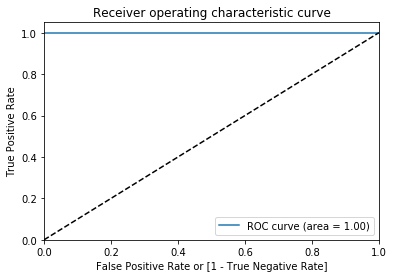

(array([0., 1.]), array([1., 1.]), array([1, 0], dtype=int64))

In [22]:
n_splits           =  10
random_state       =  1234
scoring            = 'roc_auc'

kfold              =  KFold(n= X_train.shape[0],n_folds = n_splits, random_state = random_state)

auc_train          = cross_val_score(clf, X_train, y_train,  scoring = scoring) 
print("\nTraining data")
draw_roc( y_train, predicted_train)    

In [23]:
#Predict the response for test dataset
predicted_testing = clf.predict(X_test)


Testing Data
[[117  33]
 [ 33  48]]


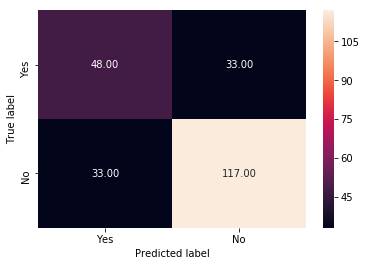

Testing Accuracy: 71.429%


In [24]:
matrix             = confusion_matrix(y_test, predicted_testing)
print("\nTesting Data")
print(matrix)
draw_cm(y_test, predicted_testing )
    
accuracy_train = clf.score(X_test, y_test) 
print("Testing Accuracy: %.3f%%" % (accuracy_train * 100.0))

In [25]:
measures_test      = classification_report(y_test, predicted_testing) 
print("\nTesting data")
print(measures_test) 


Testing data
             precision    recall  f1-score   support

          0       0.78      0.78      0.78       150
          1       0.59      0.59      0.59        81

avg / total       0.71      0.71      0.71       231




Testing  data


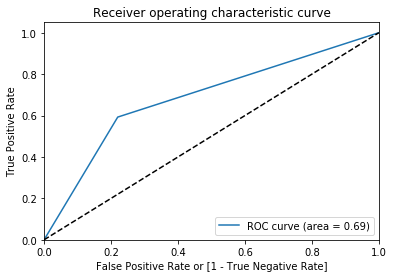

(array([0.  , 0.22, 1.  ]),
 array([0.        , 0.59259259, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [26]:
print("\nTesting  data")
draw_roc( y_test, predicted_testing)  

Recursive partitioning is a fundamental tool in data mining. It helps us explore the structure of a set of data, while developing easy to visualize decision rules for predicting a categorical (classification tree) or continuous (regression tree) outcome.

CART Modeling via DecisionTreeClassifier

Classification and Regression Trees (as described by Brieman, Freidman, Olshenm and Stone) can be generated through the DecisionTreeClassifier package.

i) Grow the tree

For controlling tree growth, we set the following parameters:
* max_depth: The maximum depth of the tree.
* min_samples_split: The minimum number of samples required to split an internal node
* min_samples_leaf: min no of samples at a leaf node
* min_impurity_decrease : A node will be split if this split induces a decrease of the impurity greater than or equal to this value. 

In [27]:
feature_names =  ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree','age']
class_names   =  ['No Diabetes','Diabetes']

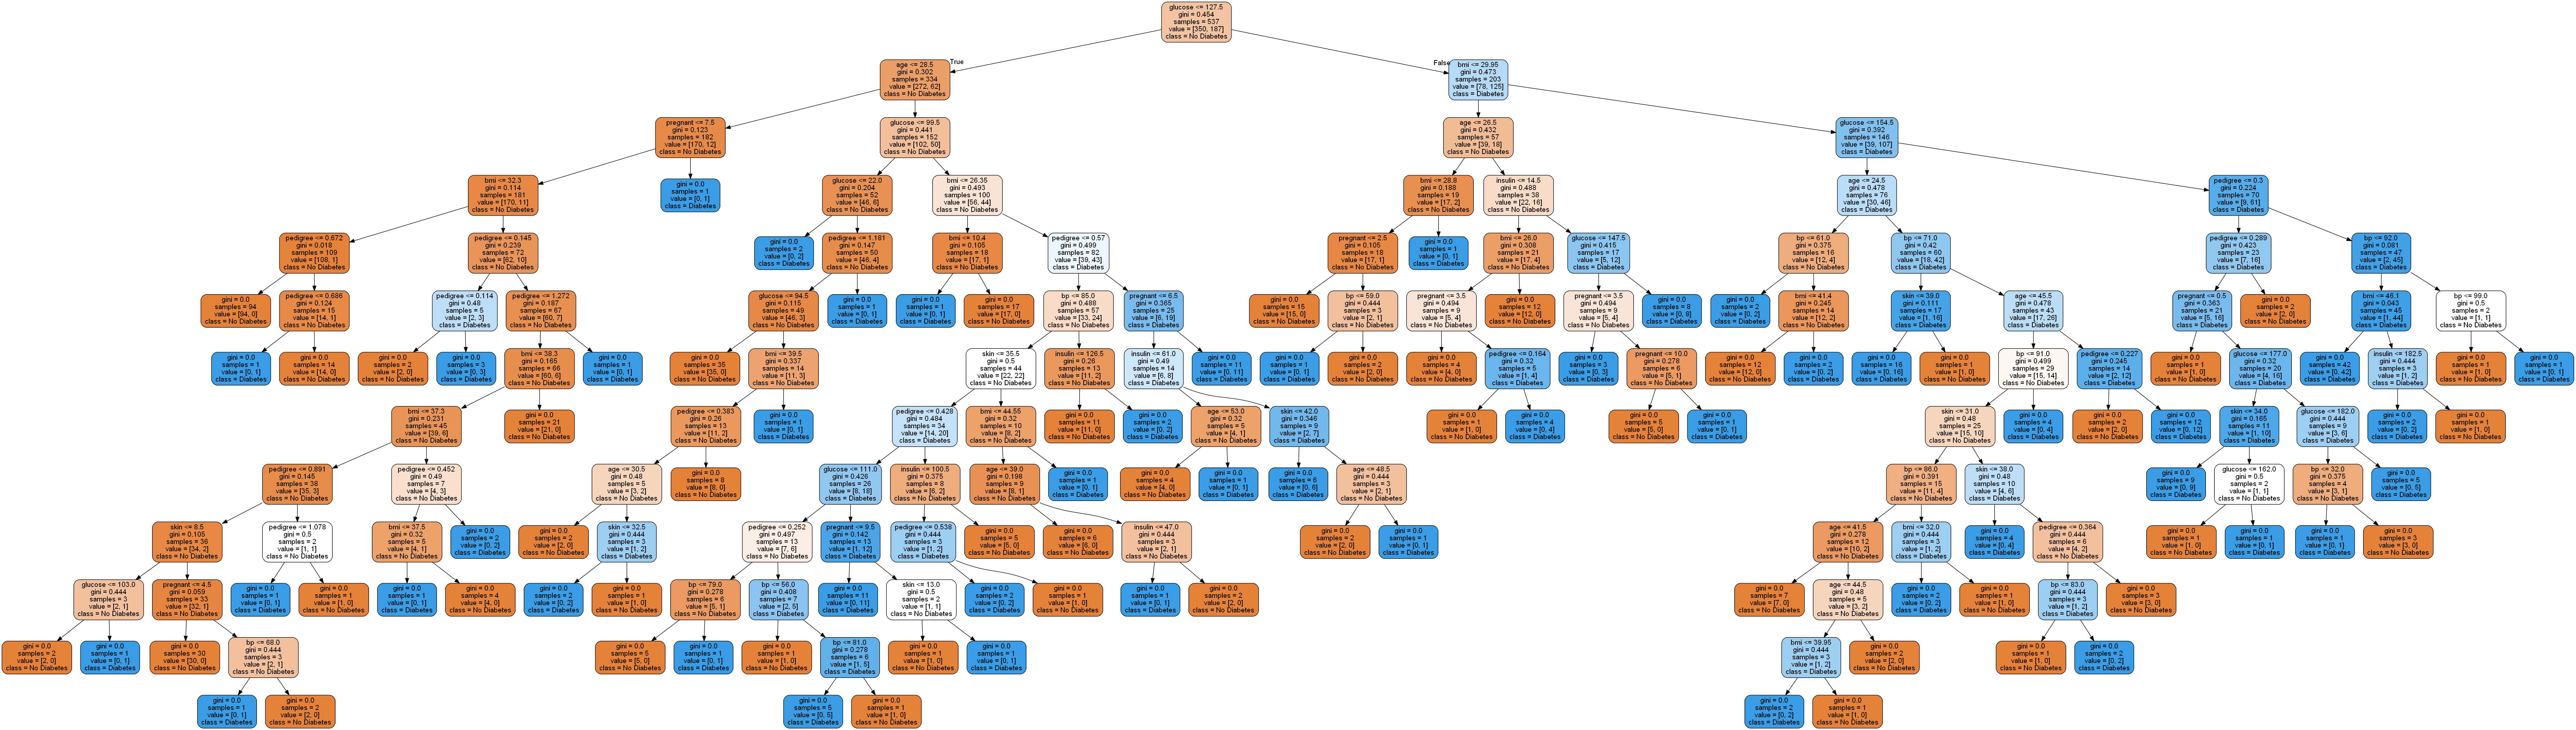

In [28]:
decision_tree_no_pruning(clf, X_train, y_train, feature_names, 'diabetes')

We observe that the above tree is unpruned and it is unexplainable and difficult to comprehend. 
Let us improve the graph by pruning.

### Optimize Decision Tree performance

Let us look at the following parameters:

| Parameter | Details                            |
| ----------------- | --------------------------------------------------------|
| criterion | This parameter allows us to use the different-different attribute selection measure.    Allowed criteria are “gini” (default) for the Gini index and “entropy” for the information gain.|
| splitter  | This parameter allows us to choose the split strategy. Allowed strategies are “best” to  choose the best split and “random” to choose the best random split| 
| max_depth | This parameter allows us to state the maximum depth of the tree. If None, then nodes are  expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting |

### Prune and check the performance of the pruned tree

In [29]:
clf1    =   DecisionTreeClassifier(criterion="entropy", max_depth = 4, min_impurity_decrease = 0)
clf1.fit(X_train, y_train)
#Predict the response for train dataset
predicted_train = clf1.predict(X_train)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_train, predicted_train))

Accuracy: 0.8026070763500931


In [30]:
measures_train     = classification_report(y_train, predicted_train) 
print("\nTraining data")
print(measures_train) 


Training data
             precision    recall  f1-score   support

          0       0.92      0.76      0.83       350
          1       0.66      0.88      0.76       187

avg / total       0.83      0.80      0.81       537



### Optimum cut-off

We know the data set is not balanced and hence the standard cut-off of 50% for creating the confusion matrix will not hold good. We need to find the optimum cut-off to divide the data set into two classes.

In [31]:
"""
  This function calculates the Youdens J score which gives the optimum cut-off point given the fpr, tpr and thresholds
"""
def get_youdens_j_cutoff(fpr,tpr,thresholds):
    j_scores = np.abs(tpr - fpr)
    j_ordered = sorted(zip(j_scores,thresholds, fpr, tpr))
    # Plot tpr vs 1-fpr
    fig, ax = plt.subplots()
    plt.plot(tpr)
    plt.plot(1-fpr, color = 'red')
    plt.xlabel('1-False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ax.set_xticklabels([])
    res = {'fpr': j_ordered[-1][2], 'tpr': j_ordered[-1][3], 'threshold' : j_ordered[-1][1]}
    return res

In [32]:
predicted_proba_tr = clf1.predict_proba(X_train)

In [33]:
print(predicted_proba_tr[:5,1])

[0.18867925 0.14634146 0.52439024 0.00917431 0.        ]


In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
threshold_df            =  pd.DataFrame()  
threshold_df['Actual']  = y_train
threshold_df.dropna(inplace = True)

In [36]:
threshold_values = np.arange(0.10,0.80,0.02)

cutoff_df        = pd.DataFrame()

for i in range(len(threshold_values)):
    
    threshold                   = threshold_values[i]
    threshold_df['Probability'] = predicted_proba_tr[:,1]
    threshold_df['pred']        = threshold_df['Probability'].map(lambda x: 1 \
                                                                  if x > threshold else 0)
    cm                          = confusion_matrix(threshold_df['Actual'].astype('int'),\
                                                   threshold_df['pred'])
    precision                   = np.diag(cm) / np.sum(cm, axis = 0)
    recall                      = np.diag(cm) / np.sum(cm, axis = 1) 
    accuracy_ratio              = ((cm[0,0] + cm[1,1]) * 100) / (cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    #auroc                       = 
    recall_positive             = recall[1]
    precision_positive          = precision[1]
    cutoff_df_ind               = pd.DataFrame({'Threshold': threshold, 'Recall' : recall_positive,\
                                               'Precision' : precision_positive,\
                                               'Accuracy Ratio' : accuracy_ratio},\
                                              index = [0])
    print(cutoff_df_ind)
    print(cm)
    cutoff_df.append(cutoff_df_ind)  
print(cutoff_df.head())

   Threshold    Recall  Precision  Accuracy Ratio
0        0.1  0.994652   0.505435       65.921788
[[168 182]
 [  1 186]]
   Threshold    Recall  Precision  Accuracy Ratio
0       0.12  0.994652   0.505435       65.921788
[[168 182]
 [  1 186]]
   Threshold    Recall  Precision  Accuracy Ratio
0       0.14  0.994652   0.505435       65.921788
[[168 182]
 [  1 186]]
   Threshold    Recall  Precision  Accuracy Ratio
0       0.16  0.962567   0.550459        71.32216
[[203 147]
 [  7 180]]
   Threshold    Recall  Precision  Accuracy Ratio
0       0.18  0.962567   0.550459        71.32216
[[203 147]
 [  7 180]]
   Threshold    Recall  Precision  Accuracy Ratio
0        0.2  0.887701   0.656126       79.888268
[[263  87]
 [ 21 166]]
   Threshold    Recall  Precision  Accuracy Ratio
0       0.22  0.887701   0.656126       79.888268
[[263  87]
 [ 21 166]]
   Threshold    Recall  Precision  Accuracy Ratio
0       0.24  0.887701   0.656126       79.888268
[[263  87]
 [ 21 166]]
   Threshold    

{'fpr': 0.23714285714285716,
 'threshold': 0.524390243902439,
 'tpr': 0.8770053475935828}

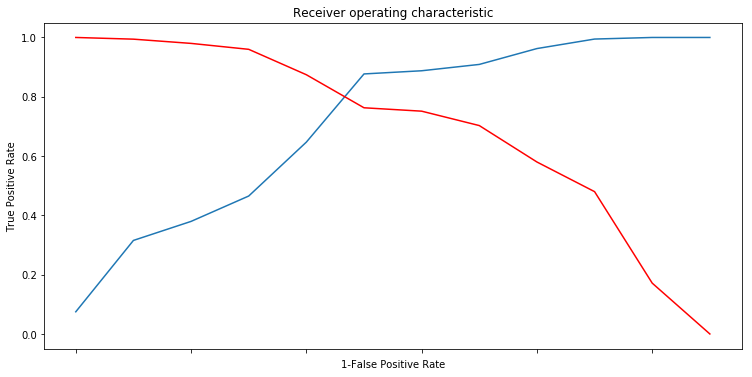

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, threshold_df['Probability'], \
                                         drop_intermediate = True )
get_youdens_j_cutoff(fpr, tpr, thresholds)  

### Metrics for Test data

In [38]:
#Predict the response for test dataset
predicted_test = clf1.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, predicted_test))

Accuracy: 0.7186147186147186


In [39]:
#Predict the response for test dataset
measures_test      = classification_report(y_test, predicted_test) 
print("\nTesting data")
print(measures_test) 


Testing data
             precision    recall  f1-score   support

          0       0.83      0.71      0.77       150
          1       0.58      0.74      0.65        81

avg / total       0.74      0.72      0.72       231




Testing Data
[[106  44]
 [ 21  60]]


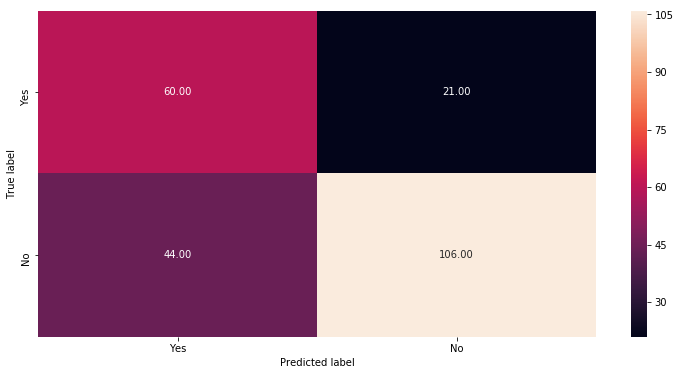

Testing Accuracy: 71.861%

Testing data
             precision    recall  f1-score   support

          0       0.83      0.71      0.77       150
          1       0.58      0.74      0.65        81

avg / total       0.74      0.72      0.72       231



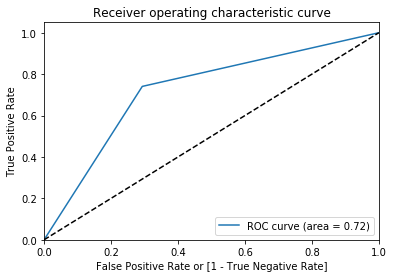

(array([0.        , 0.29333333, 1.        ]),
 array([0.        , 0.74074074, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [40]:
#Predict the response for test dataset
predicted_testing = clf1.predict(X_test)
matrix             = confusion_matrix(y_test, predicted_testing)
print("\nTesting Data")
print(matrix)
draw_cm(y_test, predicted_testing )
    
accuracy_train = clf1.score(X_test, y_test) 
print("Testing Accuracy: %.3f%%" % (accuracy_train * 100.0))
measures_test      = classification_report(y_test, predicted_testing) 
print("\nTesting data")
print(measures_test) 
draw_roc( y_test, predicted_testing) 

There is an increase in the Accuracy score after pruning.


Threshold is 0.500 

[[ 60  21]
 [ 44 106]]


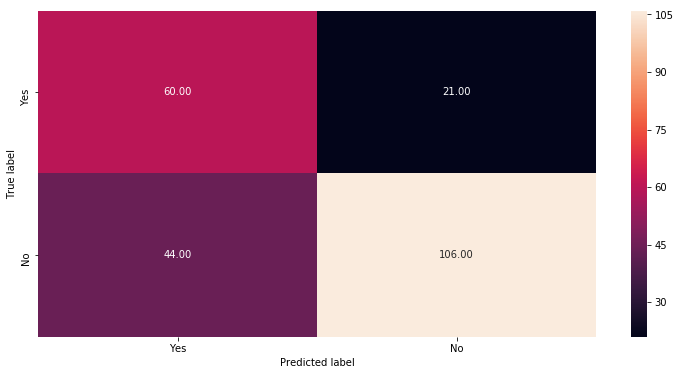

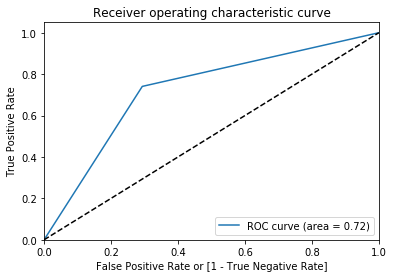

   Threshold    Recall  Precision  Accuracy Ratio
0        0.5  0.706667   0.834646       71.861472

Threshold is 0.520 

[[ 60  21]
 [ 44 106]]


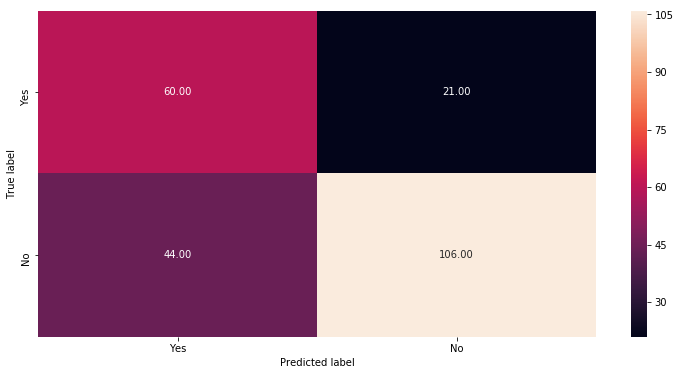

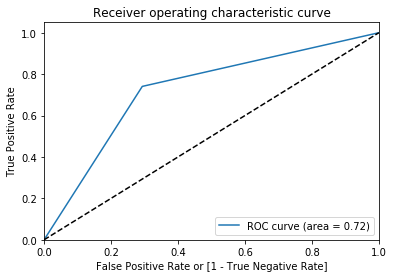

   Threshold    Recall  Precision  Accuracy Ratio
0       0.52  0.706667   0.834646       71.861472


In [42]:
predicted_proba_test              = clf1.predict_proba(X_test)
threshold__test_df                =  pd.DataFrame()  
threshold__test_df ['Actual']     =  y_test
threshold__test_df.dropna(inplace = True)
threshold_values                  = np.arange(0.50,0.52,0.02)
cutoff_df                         = pd.DataFrame()

for i in range(len(threshold_values)):
    
    threshold                         = threshold_values[i]
    print("\nThreshold is %0.3f" %threshold,"\n")
    threshold__test_df['Probability'] = predicted_proba_test[:,1]
    threshold__test_df['pred']        =  threshold__test_df['Probability'].map(lambda x: 1 \
                                                                  if x > threshold else 0)
    cm                                = confusion_matrix(threshold__test_df['Actual'].astype('int'),\
                                                   threshold__test_df['pred'],[1,0])
    print(cm)
    draw_cm(threshold__test_df['Actual'].astype('int'),\
                                                   threshold__test_df['pred'])
    draw_roc(threshold__test_df['Actual'].astype('int'),\
                                                   threshold__test_df['pred']) 
    precision                         = np.diag(cm) / np.sum(cm, axis = 0)
    recall                            = np.diag(cm) / np.sum(cm, axis = 1) 
    accuracy_ratio                    = ((cm[0,0] + cm[1,1]) * 100) / (cm[0,0] + cm[1,1] + cm[0,1] + cm[1,0])
    recall_positive                   = recall[1]
    precision_positive                = precision[1]
    cutoff_df_ind                     = pd.DataFrame({'Threshold': threshold, 'Recall' : recall_positive,\
                                               'Precision' : precision_positive,\
                                               'Accuracy Ratio' : accuracy_ratio},\
                                              index = [0])
    print(cutoff_df_ind)

    cutoff_df.append(cutoff_df_ind)  


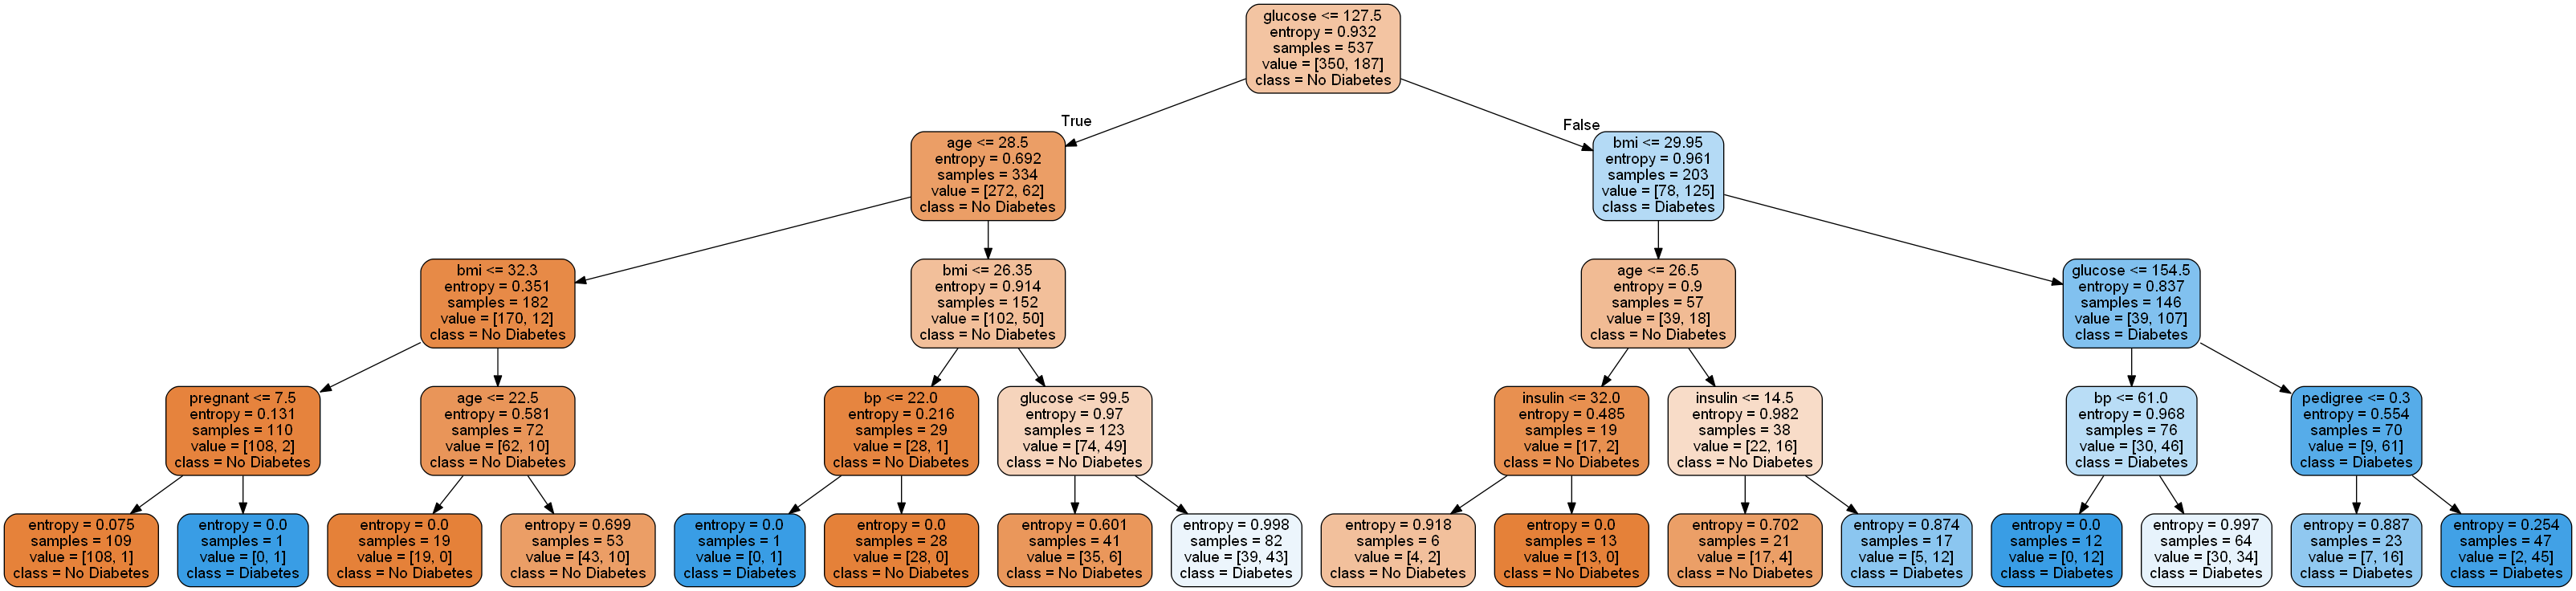

In [43]:
decision_tree_with_pruning(clf1, X_train, y_train, feature_names, 'diabetes')

tree_to_code(clf1, list(X_train.loc[:,feature_names]))

How do you interpret the tree or understand the rules from the above picture?

In [44]:
tree_to_rules(clf1, list(X_train.loc[:,feature_names]), class_names)

 if ( glucose <= 127.5 ) {
   if ( age <= 28.5 ) {
     if ( bmi <= 32.30000305175781 ) {
       if ( pregnant <= 7.5 ) {
         Class = No Diabetes
       } else {
         Class = Diabetes
       }
     } else {
       if ( age <= 22.5 ) {
         Class = No Diabetes
       } else {
         Class = No Diabetes
       }
     }
   } else {
     if ( bmi <= 26.350000381469727 ) {
       if ( bp <= 22.0 ) {
         Class = Diabetes
       } else {
         Class = No Diabetes
       }
     } else {
       if ( glucose <= 99.5 ) {
         Class = No Diabetes
       } else {
         Class = Diabetes
       }
     }
   }
 } else {
   if ( bmi <= 29.950000762939453 ) {
     if ( age <= 26.5 ) {
       if ( insulin <= 32.0 ) {
         Class = No Diabetes
       } else {
         Class = No Diabetes
       }
     } else {
       if ( insulin <= 14.5 ) {
         Class = No Diabetes
       } else {
         Class = Diabetes
       }
     }
   } else {
     if ( glucose <= 154.5 ) {
    

https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

### Variable importance plot

In [45]:
varImp_df   = pd.DataFrame({'Feature_names' :feature_names,\
                            'Importances' : clf1.feature_importances_})
varImp_df.sort_values('Importances', ascending = False) 

,Feature_names,Importances
1,glucose,0.446496
5,bmi,0.194677
7,age,0.174833
2,bp,0.073512
4,insulin,0.052435
6,pedigree,0.029495
0,pregnant,0.028552
3,skin,0.000000


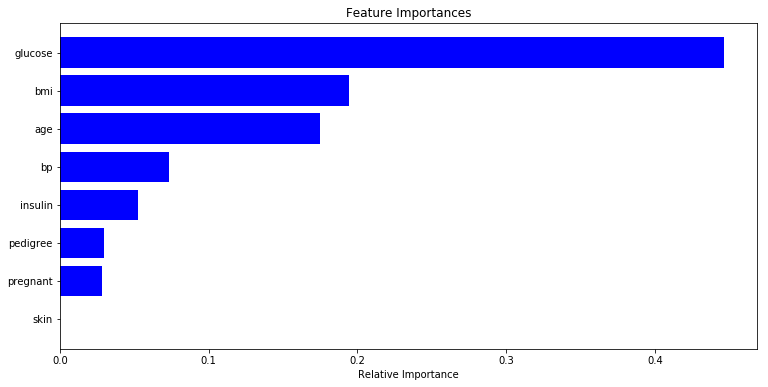

In [46]:
importances = clf1.feature_importances_
indices     = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()